There are 100+ types of flowers which are to be classified. A labeled set is given for training. In this kernel I will make a Residual Network for the problem statement. Previously I used VGG16 and GoogLeNet network to train on the same dataset.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/train-data/train.csv
/kaggle/input/train-data/train_X.npy


In [2]:
import pandas as pd
import tensorflow as tf
import keras.backend as K
from keras.utils import to_categorical 
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, ZeroPadding2D, BatchNormalization, Dropout, Dense, Flatten, Activation, Add, concatenate
from keras.initializers import glorot_uniform, he_uniform, Zeros
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [3]:
train_X = np.load("/kaggle/input/train-data/train_X.npy")

train_y = np.asarray(pd.read_csv("/kaggle/input/train-data/train.csv").iloc[:,1])

train_y = to_categorical(train_y)

Residual Identity Block

In [4]:
kernel_init = glorot_uniform()

def identity_block(X, F1, F2, F3, k, stage, block):
    conv_name_base = 'Conv'+str(stage)+str(block)
    bn_name_base = 'BN'+str(stage)+str(block)
    
    X_shortcut = X # I will need this to add with convolutional o/p
    
    X = Conv2D(F1, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_initializer=kernel_init, name=conv_name_base+'2a')(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'_a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2, kernel_size=(k,k), strides=(1,1), padding='same', kernel_initializer=kernel_init, name=conv_name_base+'2b')(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'_b')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F3, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_initializer=kernel_init, name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'_c')(X)
    
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

Residual Convolutional Block

In [5]:
def convolutional_block(X, F1, F2, F3, k, s, stage, block):
    conv_name_base = 'Conv'+str(stage)+str(block)
    bn_name_base = 'BN'+str(stage)+str(block)
    
    X_shortcut = X # I will need this to add with convolutional o/p
    X_shortcut = Conv2D(F3, kernel_size=(1,1), strides=(s,s), padding='valid', kernel_initializer=kernel_init, name=conv_name_base+'1')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(X_shortcut)
    
    X = Conv2D(F1, kernel_size=(1,1), strides=(s,s), padding='valid', kernel_initializer=kernel_init, name=conv_name_base+'2a')(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'_a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2, kernel_size=(k,k), strides=(1,1), padding='same', kernel_initializer=kernel_init, name=conv_name_base+'2b')(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'_b')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F3, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_initializer=kernel_init, name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'_c')(X) 
    
    
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

Resnet50 Network

In [6]:
X_input = Input(shape=(100,100,3))

    
# Zero-Padding
X = ZeroPadding2D((3, 3))(X_input)
    
# Stage 1
X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)

# Stage 2
X = convolutional_block(X, k= 3, F1=64, F2=64, F3=256, stage = 2, block='a', s = 1)
X = identity_block(X, k=3, F1=64, F2=64, F3=256, stage=2, block='b')
X = identity_block(X, k=3, F1=64, F2=64, F3=256, stage=2, block='c')

# Stage 3
X = convolutional_block(X, k=3, F1=128, F2=128, F3=512, stage=3, block='a', s=2)
X = identity_block(X, k=3, F1=128, F2=128, F3=512, stage=3, block='b')
X = identity_block(X, k=3, F1=128, F2=128, F3=512, stage=3, block='c')
X = identity_block(X, k=3, F1=128, F2=128, F3=512, stage=3, block='d')

# Stage 4
X = convolutional_block(X, k=3, F1=256, F2=256, F3=1024, stage=4, block='a', s=2)
X = identity_block(X, k=3, F1=256, F2=256, F3=1024, stage=4, block='b')
X = identity_block(X, k=3, F1=256, F2=256, F3=1024, stage=4, block='c')
X = identity_block(X, k=3, F1=256, F2=256, F3=1024, stage=4, block='d')
X = identity_block(X, k=3, F1=256, F2=256, F3=1024, stage=4, block='e')
X = identity_block(X, k=3, F1=256, F2=256, F3=1024, stage=4, block='f')

# Stage 5
X = convolutional_block(X, k=3, F1=512, F2=512, F3=2048, stage=5, block='a', s=2)
X = identity_block(X, k=3, F1=512, F2=512, F3=2048, stage=5, block='b')
X = identity_block(X, k=3, F1=512, F2=512, F3=2048, stage=5, block='c')

# AVGPOOL
X = AveragePooling2D(pool_size=(2,2), padding='same')(X)

# Output layer
X = Flatten()(X)
X = Dense(103, activation='softmax', name='fc' + str(103), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    

In [7]:
# Create model
model = Model(inputs = X_input, outputs = X, name='ResNet50')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.fit(train_X, train_y, validation_split=0.2, epochs = 100, batch_size=128)

Train on 14832 samples, validate on 3708 samples
Epoch 1/100
14832/14832 [==============================] - 70s 5ms/step - loss: 5.3854 - accuracy: 0.0657 - val_loss: 4.2890 - val_accuracy: 0.0386
Epoch 2/100
14832/14832 [==============================] - 37s 3ms/step - loss: 3.0812 - accuracy: 0.2685 - val_loss: 3.6046 - val_accuracy: 0.1456
Epoch 3/100
14832/14832 [==============================] - 37s 3ms/step - loss: 2.2481 - accuracy: 0.4291 - val_loss: 2.4107 - val_accuracy: 0.3530
Epoch 4/100
14832/14832 [==============================] - 37s 3ms/step - loss: 1.7391 - accuracy: 0.5468 - val_loss: 2.8286 - val_accuracy: 0.3778
Epoch 5/100
14832/14832 [==============================] - 37s 3ms/step - loss: 1.2095 - accuracy: 0.6713 - val_loss: 2.1128 - val_accuracy: 0.4175
Epoch 6/100
14832/14832 [==============================] - 37s 3ms/step - loss: 0.8480 - accuracy: 0.7783 - val_loss: 2.3396 - val_accuracy: 0.4291
Epoch 7/100
14832/14832 [==============================] - 37s 

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


Text(0.5, 0, 'Epochs')

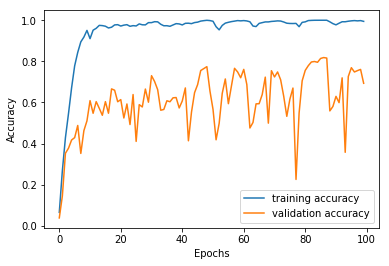

In [9]:
import matplotlib.pyplot as plt 
print(model.history.history.keys())
plt.figure(1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')